In [0]:
!pip install imageio

import imageio
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive

# drive.mount('/content/gdrive')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Utils

Loading

In [0]:
def load_bboxes(filepath):
  return np.loadtxt(filepath, delimiter=',', dtype=np.int32)

def load_imgs(indices):
  dir_path = 'gdrive/My Drive/BE537/region_dir/'
  imgs = np.zeros([ len(indices), 256, 256, 3])
  for i in range(len(indices)):
    filepath = dir_path + str(indices[i]).zfill(7) + '.png'
    imgs[i, :, :, :] = imageio.imread(filepath).reshape([256, 256, 3])
  return imgs

Augmentation

In [0]:
def normalize(imgs):
  mu = np.zeros(imgs.shape)
  mu[:, :, :, 0] = np.mean(imgs[:, :, :, 0])
  mu[:, :, :, 1] = np.mean(imgs[:, :, :, 1])
  mu[:, :, :, 2] = np.mean(imgs[:, :, :, 2])
  
  sigma = np.zeros(imgs.shape)
  sigma[:, :, :, 0] = np.std(imgs[:, :, :, 0])
  sigma[:, :, :, 1] = np.std(imgs[:, :, :, 1])
  sigma[:, :, :, 2] = np.std(imgs[:, :, :, 2])
  
  normalized = np.divide(imgs - mu, sigma)
  return normalized

def flip_images(imgs):
  probability = 0.5
  n = imgs.shape[0]
  rand_arr = np.random.random(n)
  rand_indices = rand_arr >= probability
  imgs[rand_indices, :, :, :] = np.fliplr(imgs[rand_indices, : ,: , :])
  return imgs

Batch Selection

In [0]:
def get_class_indices(labels):
  tangle_indices = np.nonzero(labels==0)[0]
  thread_indices = np.nonzero(labels)[0]
  return tangle_indices, thread_indices

def batch_permutation(batch_size, indices):
  half_batch_size = int(np.floor(batch_size/2))
  class_num = len(indices)
  permutation = np.random.permutation(class_num)
  permutation = permutation[0:batch_size]
  return indices[permutation]

def oversample_batch(imgs, labels, tangle_indices, thread_indices, batch_size):
  tangle_permutation = batch_permutation(batch_size, tangle_indices)
  thread_permutation = batch_permutation(batch_size, thread_indices)
  
  tangle_imgs = imgs[tangle_permutation, :, :, :]
  thread_imgs = imgs[thread_permutation, :, :, :]
  
  tangle_labels = labels[tangle_permutation]
  thread_labels = labels[thread_permutation]
  
  batch_imgs = np.vstack((tangle_imgs, thread_imgs))
  batch_labels = np.concatenate((tangle_labels, thread_labels))
  return batch_imgs, batch_labels

def imbalanced_batch(imgs, labels, batch_size):
  permutation = np.random.permutation(len(labels))
  permutation = permutation[0:batch_size]
  
  batch_imgs = imgs[permutation, :, :, :]
  batch_labels = labels[permutation]
  return batch_imgs, batch_labels

# Load Data

In [0]:
# # Load BBox
# bbox_filepath = 'gdrive/My Drive/BE537/regions_bbox.csv'
# bboxes = load_bboxes(bbox_filepath)

# # # Load and Save Images as Npy
# # train_data = load_imgs(np.arange(int(np.floor(0.8*bboxes.shape[0]))))
# # test_data = load_imgs(np.arange(int(np.floor(0.8*bboxes.shape[0])), bboxes.shape[0]))
# # save_dir = 'gdrive/My Drive/BE537/'
# # np.save(save_dir + 'train_imgs.npy', train_data)
# # np.save(save_dir + 'test_imgs.npy', test_data)

In [0]:
# Can use if you've already generated train_test_data

# Get data
# train_data = np.load('gdrive/My Drive/BE537/train_data.npy')
# test_data = np.load('gdrive/My Drive/BE537/test_data.npy')

train_imgs = normalize(np.load('gdrive/My Drive/BE537/train_imgs.npy'))
test_imgs = normalize(np.load('gdrive/My Drive/BE537/test_imgs.npy'))

train_labels = np.load('gdrive/My Drive/BE537/train_labels.npy').astype(np.int32)
test_labels = np.load('gdrive/My Drive/BE537/test_labels.npy').astype(np.int32)

# # Separate data and labels
# train_labels = train_data[:, 4].astype(np.int32)
# train_bbox = train_data[:,0:4]

# test_labels = test_data[:, 4].astype(np.int32)
# test_bbox = test_data[:, 0:4]

# one hot encode labels
# n_values = np.max(train_labels_pre) + 1
# train_labels = np.eye(n_values)[train_labels_pre]
# test_labels = np.eye(n_values)[test_labels_pre]

# Exploratory Data Analysis

Summary Statistics About the Data Set

In [0]:
dataset_class_ratio = np.sum(bboxes[:, 4])/bboxes.shape[0] # tangle: 0, thread: 1
print("Ratio of tangles to threads in full dataset: ", dataset_class_ratio)

# 80/20 split ratio
split_idx = int(np.floor(0.8*bboxes.shape[0]))
train_data = bboxes[0:split_idx, :]
test_data = bboxes[split_idx:, :]

train_ratio = np.sum(train_data[:, 4])/train_data.shape[0]
test_ratio = np.sum(test_data[:, 4])/test_data.shape[0]

print("Ratio of tangles to threads in training: ", train_ratio)
print("Ratio of tangles to threads in test: ", test_ratio)

print('') # empty line

# Basic Stats about size of bounding boxes
full_avg_width = np.mean(bboxes[:, 2])
train_avg_width = np.mean(train_data[:, 2])
test_avg_width = np.mean(test_data[:, 2])

print("Dataset Average BBox Width: ", full_avg_width)
print("Training Data Average BBox Width: ", train_avg_width)
print("Test Average BBox Width: ", test_avg_width)

print(" ")

full_avg_height = np.mean(bboxes[:, 3])
train_avg_height = np.mean(train_data[:, 3])
test_avg_height = np.mean(test_data[:, 3])

print("Dataset Average BBox Height: ", full_avg_height)
print("Training Data Average BBox Height: ", train_avg_height)
print("Test Average BBox Height: ", test_avg_height)

print(" ")

full_avg_height = np.mean(bboxes[:, 3])

full_average_box_area = np.mean(np.multiply(bboxes[:, 2], bboxes[:, 3]))
train_average_box_area = np.mean(np.multiply(train_data[:, 2], train_data[:, 3]))
test_average_box_area = np.mean(np.multiply(test_data[:, 2], test_data[:, 3]))

print("Dataset Average Bounding Box Area: ", full_average_box_area)
print("Training Data Average Bounding Box Area", train_average_box_area)
print("Test Data Average Bounding Box Area", test_average_box_area)

# Save train and test split for future
save_dir = 'gdrive/My Drive/BE537/'
np.save(save_dir + 'train_data.npy', train_data)
np.save(save_dir + 'test_data.npy', test_data)

# Layers

Convolution Layers

In [0]:
def conv_unit(x, hidden_num, kernel_size, stride, is_train, reuse):
  vs = tf.get_variable_scope()
  x = tf.layers.conv2d(
      x,
      filters=hidden_num,
      kernel_size=kernel_size,
      kernel_initializer=tf.initializers.truncated_normal(),
      strides=[stride, stride] 
  )
  x = tf.layers.batch_normalization(x, training=is_train)
  x = tf.nn.relu(x)
  return x


Fully Connected Layer

In [0]:
def fc_unit(x, hidden_num, is_train, reuse):
  vs = tf.get_variable_scope()
  in_channels = x.get_shape()[1]
  W = tf.get_variable('weights', [in_channels, hidden_num],
                      initializer=tf.initializers.truncated_normal())
  b = tf.get_variable('biases', [1, hidden_num],
                      initializer=tf.constant_initializer(0.0))
  x = tf.matmul(x, W)
  x = tf.layers.batch_normalization(x, training=is_train)
  x = tf.nn.relu(x)
  return x

Residual Block

In [0]:
def residual_unit(x, hidden_num, kernel_size, stride, is_train, reuse):
  x1 = tf.layers.conv2d(
      x,
      filters=hidden_num,
      kernel_size=kernel_size,
      kernel_initializer=tf.initializers.truncated_normal(),
      strides=[1, 1],
      padding='VALID'
  )
  x1 = tf.layers.batch_normalization(x1, training=is_train)
  with tf.variable_scope('1', reuse=reuse):
    x2 = conv_unit(x, hidden_num, 3, 1, is_train, reuse)
  with tf.variable_scope('2', reuse=reuse):
    x2 = tf.layers.conv2d(
        x2,
        filters=hidden_num,
        kernel_size=kernel_size,
        kernel_initializer=tf.initializers.truncated_normal(),
        strides=[1, 1],
        padding='SAME'
    )
  with tf.variable_scope('combine', reuse=reuse):
    x = x1 + x2
    x = tf.layers.batch_normalization(x, training=is_train)
  return x

# Models

In [0]:
def ConvNet(x, batch_size, pool_size, is_train, reuse=tf.AUTO_REUSE):
  with tf.variable_scope('ConvNet', reuse=reuse) as vs:
    hidden_num = 8
    kernel_size = 3
    stride = 2
    with tf.variable_scope('first', reuse=reuse):
      x = conv_unit(x, hidden_num, kernel_size, stride, is_train, reuse)
    with tf.variable_scope('second', reuse=reuse):
      hidden_num = hidden_num * 2
      x = conv_unit(x, hidden_num, kernel_size, stride, is_train, reuse)
    with tf.variable_scope('third', reuse=reuse):
      hidden_num = hidden_num * 2
      x = conv_unit(x, hidden_num, kernel_size, stride, is_train, reuse)
    with tf.variable_scope('fourth', reuse=reuse):
      hidden_num = hidden_num * 2
    with tf.variable_scope('fifth', reuse=reuse):
      hidden_num = hidden_num * 2
      x = conv_unit(x, hidden_num, kernel_size, stride, is_train, reuse)
    with tf.variable_scope('last', reuse=reuse):
      hidden_num = hidden_num * 2
      x = tf.layers.conv2d(
          x,
          filters=hidden_num,
          kernel_size=kernel_size,
          kernel_initializer=tf.initializers.truncated_normal(),
          strides=[stride, stride]
      )
      x_shape = x.shape
      x = tf.reshape(x, [-1, x_shape[1]*x_shape[2]*x_shape[3]])
      x = tf.nn.dropout(x, 0.5)
      x = tf.layers.dense(x, c_num, kernel_initializer=tf.initializers.truncated_normal())
    return x

In [0]:
def ResNet(x, batch_size, pool_size, is_train, reuse=tf.AUTO_REUSE):
  with tf.variable_scope('C', reuse=reuse) as vs:
    with tf.variable_scope('first', reuse=reuse):
      hidden_num = 8
      x = residual_unit(x, hidden_num, 3, 1, is_train, reuse)
      x = tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], strides=[1, 2, 2, 1], padding='SAME')
    for l in range(2):
      hidden_num = hidden_num * 2
      with tf.variable_scope('rd_conv_' + str(l), reuse=reuse):
        x = residual_unit(x, hidden_num, 3, 1, is_train, reuse)
        x = tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], strides=[1, 2, 2, 1], padding='SAME')
    with tf.variable_scope('last', reuse=reuse):
      hidden_num = 2 * hidden_num
      x = conv_unit(x, hidden_num, 3, 1, is_train, reuse)
      x = tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], strides=[1, 2, 2, 1], padding='SAME')
      x_shape = x.shape
      x = tf.reshape(x, [-1, x_shape[1]*x_shape[2]*x_shape[3]])

    feat = x
#     x = tf.nn.dropout(x, 0.9)
    x = tf.layers.dense(x, c_num, kernel_initializer=tf.initializers.truncated_normal())
      
  return x

# Experiments for Trianing Models

In [0]:
# Graph/Plot Config
alpha = 0.001
batch_size = 64
color_channels = 3
c_num = 2
iterations = 600
lr = .001
run_name = 'ResNet_SGD_lr001'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
train_tangle_indices, train_thread_indices = get_class_indices(train_labels)

# reset graph between runs
tf.reset_default_graph()

# allocate memory for data and labels
data = tf.placeholder(tf.float32, [None, 256, 256, color_channels])
labels = tf.placeholder(tf.int32, [None])
training= tf.placeholder(tf.bool)

#ResNet
# x = ConvNet(data, batch_size, 2, training)
x = ResNet(data, batch_size, 2, training)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.one_hot(labels, 2),
    logits=x,
    name='sigmoid_cross_entropy_loss'
))

# Predictions
predictions = tf.cast(tf.argmax(tf.nn.softmax(x), axis=1), dtype=tf.int32)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(predictions, labels)))

mean_pred = tf.reduce_mean(tf.to_float(predictions))

# Additional Metrics
TP = tf.count_nonzero(predictions * labels)
TN = tf.count_nonzero((predictions - 1) * (labels - 1))
FP = tf.count_nonzero(predictions * (labels - 1))
FN = tf.count_nonzero((predictions - 1) * labels)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = 2 * precision * recall / (precision + recall)

# Optimize
opt = tf.train.GradientDescentOptimizer(lr).minimize(loss)

with tf.Session(config=config) as sess:
  # initialize variables
  sess.run(tf.global_variables_initializer())
  
  # Initialization for Plots
  training_loss = np.zeros([iterations])
  training_accuracy = np.zeros([iterations])
  training_pred = np.empty([iterations])
  test_loss = np.zeros([iterations])
  test_accuracy = np.zeros([iterations])
  
  # Reusable Vars
  
  
  for iteration in range(iterations):
    # Get batch data
    batch_data, batch_labels = oversample_batch(
        train_imgs, 
        train_labels, 
        train_tangle_indices, 
        train_thread_indices, 
        batch_size
    )
#     batch_data, batch_labels = imbalanced_batch(train_imgs, train_labels, batch_size)
    
    # Run Session
    loss_training, _ = sess.run(
        [loss, opt],
        feed_dict={
            data: batch_data,
            labels: batch_labels,
            training: True
        }
    )
    training_loss[iteration] = loss_training
    training_accuracy[iteration] = accuracy.eval(
        feed_dict={
            data: batch_data,
            labels: batch_labels,
            training: False
        }
    )
    training_pred[iteration] = mean_pred.eval(
        feed_dict={
            data: batch_data,
            labels: batch_labels,
            training: False
        }
    )
    
    test_loss[iteration] = loss.eval(
        feed_dict={
            data: test_imgs,
            labels: test_labels,
            training: False
        }
    )
    test_accuracy[iteration] = accuracy.eval(
        feed_dict={
            data: test_imgs,
            labels: test_labels,
            training: False
        }
    )
    
    if iteration % 100 == 0:
      print("Iteration: ", iteration)
      print("Training Loss: ", training_loss[iteration], "Training Accuracy: ", training_accuracy[iteration], "Mean Prediction: ", training_pred[iteration])
  f1 = F1.eval(
        feed_dict={
            data: test_imgs,
            labels: test_labels,
            training: False
        }        
    )
  Precision = precision.eval(
      feed_dict={
          data: test_imgs,
          labels: test_labels,
          training: False
      }        
  )
  Recall = recall.eval(
      feed_dict={
          data: test_imgs,
          labels: test_labels,
          training: False
      }        
  )

Iteration:  0
Training Loss:  48.92107009887695 Training Accuracy:  0.515625 Mean Prediction:  0.375
Iteration:  100
Training Loss:  17.878021240234375 Training Accuracy:  0.53125 Mean Prediction:  0.8125
Iteration:  200
Training Loss:  13.644281387329102 Training Accuracy:  0.4609375 Mean Prediction:  0.8203125
Iteration:  300
Training Loss:  12.667191505432129 Training Accuracy:  0.453125 Mean Prediction:  0.890625
Iteration:  400
Training Loss:  12.204840660095215 Training Accuracy:  0.5234375 Mean Prediction:  0.9453125
Iteration:  500
Training Loss:  6.9999284744262695 Training Accuracy:  0.5078125 Mean Prediction:  0.9453125


In [0]:
training_loss = training_loss[0:iteration - 1]
training_accuracy = training_accuracy[0:iteration - 1]
test_accuracy = test_accuracy[0:iteration - 1]

Issues with Training


* Class Imbalace (only predict one class)
* Large Networks have memory constraints on GPU
* 




# Result Analysis

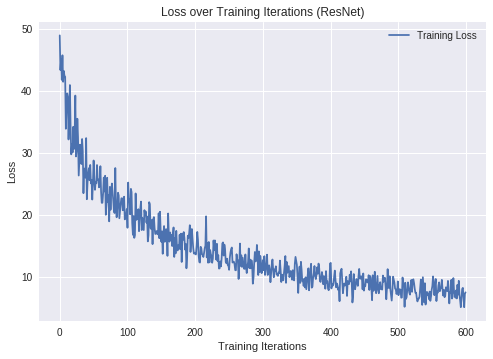

In [0]:
# Loss Plot

fig = plt.figure()
plt.plot(training_loss, label='Training Loss')
# plt.plot(test_loss, label='Test Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.title('Loss over Training Iterations (ResNet)')
plt.legend()
plt.savefig('gdrive/My Drive/BE537/' + run_name + 'loss_plot'  + '.png', dpi=300)
plt.show()

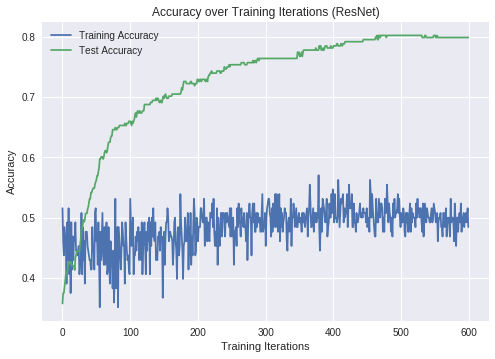

In [0]:
# Accuracy Plot

fig1 = plt.figure()
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy over Training Iterations (ResNet)')
plt.legend()
plt.savefig('gdrive/My Drive/BE537/' + run_name + 'accuracy_plot'  + '.png', dpi=300)
plt.show()

In [0]:
print(test_accuracy[iteration-1])

0.7986111044883728


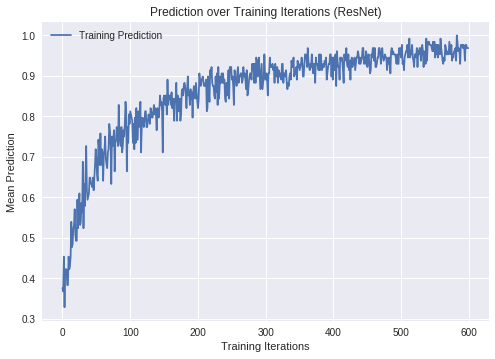

In [0]:
fig1 = plt.figure()
plt.plot(training_pred, label='Training Prediction')
plt.xlabel('Training Iterations')
plt.ylabel('Mean Prediction')
plt.title('Prediction over Training Iterations (ResNet)')
plt.legend()
plt.savefig('gdrive/My Drive/BE537/' + run_name + 'prediction_plot'  + '.png', dpi=300)
plt.show()

In [0]:
print('F1 Score: ', f1)

F1 Score:  0.88715953307393


In [0]:
print('Precision: ', Precision, 'Recall: ', Recall)

Precision:  0.8201438848920863 Recall:  0.9661016949152542


resnet3 sgd 001 - f1: .8845
resnet sgd 001 imbalance - f1: .9007, .8194 precision, recall  = 1
resnet sgd 001 balance: .88176, precision: .82014, recall: .9661